# 👋 Hi there.
This is for a general simulation procedure for any RCSB PDB structures containing ligand, with a special focous on small molecules. This notebook is only suggested for a single-chained protein ligand system, if your protein has **multiple chains**, you are suggested to use **CHARMM GUI** server to prepare your input with "solution builder" then directly go to step 7 and 9 to run your simulation. 

This notebook take http://zarbi.chem.yale.edu/ligpargen/namd_tutorial.html as a reference. This notebook is wrritten by quantaosun@gmail.com in Shanghai, China, 2021. 


This notebook needs swithing to GPU

# The tutorial uses an example structure of T4 Lysozyme L99A with a Benzene molecule bound (PDB ID: 4W52.pdb)

**The overall procedure is as below**

0.   Install Anaconda
1.   Install pymol, vmd, and openmm, pdbfixer
2.   User input a PDB ID, pdbfixer fix and prepare it
3.   separate ligand and protein
4.   generate topology for ligand using LigParGen server
5.   combine psf and pdb of protein and ligand, vmd prepare NAMD input files.
6.   Generation conf file for NAMD simulation. 
7.   GPU accelerted NAMD simulation




-------------------------------------------------------------------------
When you see a 👋 symbol, that is where you need to click the play button.
When you see a ⚠️ or ⚠️⚠️， that is where eithter need you to do some extra work or a reminder it is easy to go wrong.
-------------------------------------------------------------------------

---



In [ ]:
#@title 👋 1.Install Dependencies, this could take a while.
!mkdir external-libraries
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /home/aistudio/external-libraries
#@title Install Pymol
! yes | /home/aistudio/external-libraries/bin/conda install -c conda-forge vmd
#@title Install VMD

!yes | /home/aistudio/external-libraries/bin/conda install -c conda-forge pymol-open-source
#install openmm
!yes | /home/aistudio/external-libraries/bin/conda install -c conda-forge openmm
#install pdbfixer
!yes | /home/aistudio/external-libraries/bin/conda install -c conda-forge pdbfixer
#install visualization
! /home/aistudio/external-libraries/bin/pip install py3Dmol
# pip install pdb-tools
! /home/aistudio/external-libraries/bin/pip install pdb-tools
#install visualization
!yes | /home/aistudio/external-libraries/bin/conda install -c rdkit rdkit
#install csh shell for step 8 or step 9
!apt-get install csh
!apt-get install vim
import sys
sys.path.append('/home/aistudio/external-libraries/lib/python3.7/')
import sys
sys.path.append('/home/aistudio/external-libraries/lib/python3.7/site-packages/')
#import rdkit for visualization purpose
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import DataStructs
from rdkit.Chem import RDConfig
from rdkit.Chem import rdBase
from rdkit.Chem import MolFromPDBFile
import py3Dmol

In [ ]:

#@title 👋 2.Input a PDB id. This will download and prepare this PDB complex.

complex = "3HTB" #@param {type:"string"}
pdb = complex + ".pdb"
!wget http://www.pdb.org/pdb/files/'{pdb}'
!/home/aistudio/external-libraries/bin/pdbfixer  '{pdb}' --ph=7  --replace-nonstandard --add-residues 

To aviold later on topology issues about broken backbone and non-standard residues, it is always good to check with pymol if there is any broken backbone of your protein. If there is any, please use AlphaFold2 colab to generate a new strucure then merge ligand with this new protein, before moving on next.https://colab.research.google.com/github/deepmind/alphafold/blob/main/notebooks/AlphaFold.ipynb

To merge a ligand and a protein. First grab out the Ligand.pdb and renumber it, take the last atom number of the AlphaFold protein as a beginning. Then merge the ligand and protein, then delete all the TER and CONNECT keywords.
⚠️⚠️Don't run the next cell if your protein looks good 

In [ ]:
#@title Dont run this for now
#!pdb_fetch 1brs > 1brs.pdb
#!pdb_reres -1 1ctf.pdb > 1ctf_renumbered.pdb
#v = py3Dmol.view(query='pdb:4ylj',style={'cartoon':{'colorscheme':'ssPyMol'},'stick':{'radius':0.05}})
#v.setStyle({'resn':'4E1'},{'stick':{}})
#v.zoomTo({'resn':'4E1'})

In [ ]:
#@title ⚠️Alternatively you can upload your own protein structures from docking. In this case, you are suggested to use your local pymol instead of running step 4, as your local produced PDB file may have tricy file format compared to that of RCSB PDB bank version.

In [ ]:
#@title 👋 3.Spilit protien and ligand, capital letters only.
pdb_id = "3HTB" #@param {type:"string"}
ligand_name = "JZ4" #@param {type:"string"}
#create ligand= resn H3E 
#create active_water= resn HOH within 5 of ligand
#remove resn HOH &! active_water
com_file = open('prepare.pml','w')
com_file.write('''
load 4W52.pdb
remove resn HOH
h_add elem O or elem N
select 4W52-BNZ, resn BNZ 
select 4W52-receptor, 4W52 and not 4W52-BNZ
save 4W52-BNZ.pdb, 4W52-BNZ
save 4W52-receptor.pdb, 4W52-receptor    
''')
com_file.close()
!sed -i "s/4W52/$pdb_id/g" prepare.pml
!sed -i "s/BNZ/$ligand_name/g" prepare.pml
#@title 3.Spilit complex to protein and ligand
%cd /content/
! /home/aistudio/external-libraries/bin/pymol -c prepare.pml
#for the sake of LigParGen, we need add H atom to ligand

# 👋 ⚠️4.Download ligand, Uplaod it (Ligand should be added with H atoms before submitting.) to LigParGen, download the generated ZIP file.  Upload the *zip file here.
http://zarbi.chem.yale.edu/ligpargen/index.html 
(To add H atoms to the ligand, you could just use "h_add" in pymol)

In [ ]:
#@title 👋 ⚠️ 5. Combine and Manupilate Structures. remove any line with TER and the connectivity information. Moreover, change the residue number of Benzene ligand for continuity according to the last residue number of the protein, and add a ⚠ Chain name like ⚠️a capital B to the ligand if there is no one. then upload the complex_fixed.pdb here.
Topology_ZIP_file_name_from_LigParGen = "JZ4_D5CB2F" #@param {type:"string"}
protein_name = "3HTB-receptor" #@param {type:"string"}
ligand_name = "JZ4_D5CB2F" #@param {type:"string"}

zip = Topology_ZIP_file_name_from_LigParGen + ".zip"
protein = protein_name + ".pdb"
ligand = ligand_name + ".pdb"
%cd /content
#!unzip $zip
#!cp tmp/*.pdb ./
#!cp tmp/*.prm ./
#!cp tmp/*.rtf ./
!cat $protein  $ligand > complex.pdb

/content


In [ ]:
#@title  👋 ⚠️6. Generate ionized.pdb and ionized.psf with VMD by filling the RTF name download from LigParGen. Alternatively, you could refer to http://zarbi.chem.yale.edu/ligpargen/namd_tutorial.html 
RTF_name = "UNK_FB41F7" #@param {type:"string"}
#Download opls amino acid topology file.
!wget http://traken.chem.yale.edu/doc/top_opls_aam.inp
com_file = open('psfgen.pgn','w')
com_file.write('''
package require psfgen   
topology top_all36_prot.rtf
topology BNZ.rtf 

pdbalias HIS HSD
pdbalias atom SER HG HG1
pdbalias residue HIS HSE     
pdbalias atom ILE CD1 CD

segment A {pdb complex.pdb}  
coordpdb complex.pdb A   
guesscoord   
writepdb complex_autopsf.pdb     
writepsf complex_autopsf.psf 

package require solvate  
solvate complex_autopsf.psf complex_autopsf.pdb -t 5 -o complex_wb 
package require autoionize
autoionize -psf complex_wb.psf -pdb complex_wb.pdb -neutralize -o ionized
set ubq [atomselect top all]
measure minmax $ubq  
measure center $ubq   
exit    
''')
com_file.close()
!sed -i "s/BNZ/{RTF_name}/g" psfgen.pgn
!/home/aistudio/external-libraries/bin/vmd -dispdev text -e psfgen.pgn

YOU SHOULD MODIFY NAMD CONF FILES AS PER THE IMAGE, CHANGE PERIODIC BOUNDARY CONDITIONS BASED ON RESULT OUTPUTED BY PREVIOUS CELL
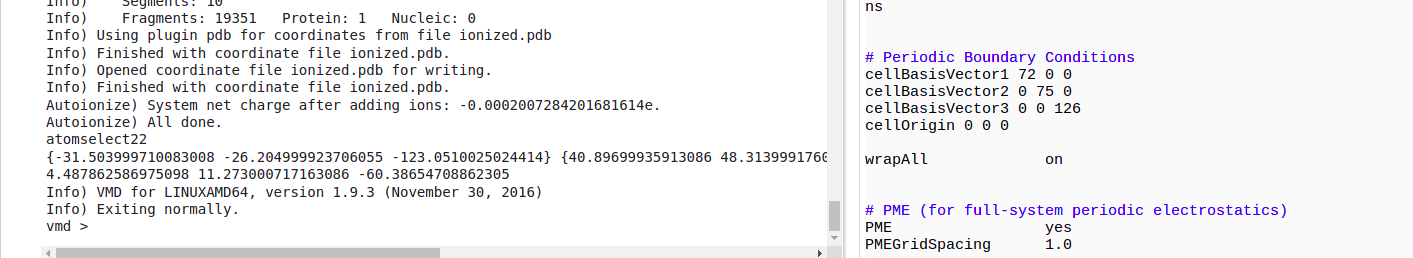

⚠️7. Download and modify the NAMD conf files, change periodic vectors in minimisation and nvt conf. Change parameter file path and simulation steps if necessary


```
# ⚠️Use the command here to measure the water box size, then put the dimension vector to the PBC section of the conf files⚠️
set all [atomselect top all] 
set mm [measure minmax $all] # use the DIMENSION between MIN and MAX for CELL BASIS VECTOR DIMENSION
measure center $all # Use the CENTER for CELLBASIS ORIGIN

```



In [ ]:
#@title Mount to Goole Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title 👋 7.Prepare NAMD software.
NAMD_tarball_PATH = "/content/drive/MyDrive/softwares/NAMD_3.0alpha8_Linux-x86_64-multicore-CUDA-SingleNode.tar.gz" #@param {type:"string"}

!tar -xvf '{NAMD_tarball_PATH}'


In [ ]:
#@title 👋 ⚠️8.Download NAMD confiles and then manually modify it acoording to current input files.If you use input files from CHARMM GUI, you can skip this step.
!wget https://raw.githubusercontent.com/quantaosun/NAMD-MD/main/min.conf
!wget https://raw.githubusercontent.com/quantaosun/NAMD-MD/main/nvt.namd
#!cp *.namd simulation
#%cd simulation
!

It is suggested that you run the simulation locally first to verify every thing is properly set up.

In [ ]:
#@title 👋 9.Run the Simulation and Copy result back to Goolge Drive every 1 ns, by default this is a 10-ns simulation
#%cd /content/simulation
#!wget https://raw.githubusercontent.com/quantaosun/NAMD-MD/main/run.csh
#!csh
#!/content/NAMD_3.0alpha8_Linux-x86_64-multicore-CUDA/namd3 +p2 nvt.namd > nvt.log
!/content/NAMD_3.0alpha8_Linux-x86_64-multicore-CUDA/namd3 +p2 npt.namd > npt.log
#!/content/NAMD_3.0alpha8_Linux-x86_64-multicore-CUDA/namd3 +p2 production.namd > production.log


# If your encounter some issue, please report it on github or write me an email quantaosun@gmail.com ヾ(￣▽￣)Bye~Bye~